# 카페 가격 비교 시스템

#### (1) 주제 선정 이유: 왜 이 주제(분야)를 선정하게 된 이유를 나열함
카카오 지도에 카페를 검색하면 개인 카페부터 프랜차이즈 카페까지 다양한 카페가 지도에 뜨게 된다.<br>
저렴한 카페를 이용하고자 하는 소비자의 입장에서는 지도에 뜨는 여러 카페 중 그나마 저렴한 가격의 커피를 파는 카페를 이용하기를 희망한다.<br>
하지만 카페 메뉴 가격을 보기 위해선 지도에 뜬 그 수많은 카페를 다 하나씩 눌러서 확인해야 한다는 문제점이 존재한다.<br>
이러한 불편한 점을 해소하기 위해 검색하고자 하는 위치의 주변의 카페 정보를 토대로 기본적인 음료 메뉴 가격을 비교해서 가격 순으로 저렴한 카페를 보여줘서 소비자가 더욱 더 편리하게 방문할 카페를 찾고자 한다.

#### (2) 가설 정의: 본인이 Term 프로젝트를 통해서 증명하고자 하는 명제 혹은 밝히고자 하는 논리가 무엇인지 설명함
카페 가격 비교 시스템이라는 Term 프로젝트를 통해 가고자 하는 주변 카페의 정보를 한눈에 확인하고 합리적인 가격의 카페를 확인하고자 한다. 이를 위해서 카카오맵을 크롤링해서 검색할 지역의 주변 카페를 selenium이라는 모듈과 BeautifulSoup를 이용해 해당 카페의 메뉴와 가격의 데이터를 모아온다. 카페 이름, 메뉴, 가격, 장소에 대한 카카오맵 정보 url을 csv파일에 저장해 pandas를 이용해서 가격 순으로 데이터를 정렬해서 합리적인 메뉴 가격을 한눈에 보고 찾아갈 수 있도록 하고자 한다.

#### (3) 인터넷을 통한 데이터 획득: 위의 명제/논리을 펼치기 위하여, 어디서 Python을 통해 어떻게 데이터를 획득했는지 구체적으로 나열함
카카오맵 사이트에서 지역을 검색하면 지역에 있는 카페 상세 url에서 Beautifulsoup를 이용해서 웹 스크래핑을 하려했지만 해당 사이트가 동적웹으로 만들어져서 상세 정보에 있는 가격표와 메뉴의 정보가 받아와지지 않는 문제가 발생했다.<br>
그래서 selenium이라는 모듈을 이용하여 크롬 드라이버로 카카오맵 브라우저를 열고 이후 자바스크립트로 동적으로 생성되는 웹이 렌더링이 완료되면 데이터를 BeautifulSoup를 이용해서 필요한 데이터를 가져오는 방식을 이용했다.<br>
크롤링 해온 데이터를 해당 지역의 이름(ex: 영통역 카페.csv)을 가진 csv 파일로 저장을 하고 추후에는 같은 지역을 검색할 시에 반복적으로 크롤링을 하지 않고 시간을 줄이기 위해 csv파일을 읽어오도록 구현했다. (여기서 데이터 열은 menu->메뉴 이름, price->메뉴 가격, title->가게 이름 으로 구섬됨 url -> 장소에 대한 카카오맵 url)<br>
총 5페이지를 크롤링해오고 한 페이지에는 대략 15개의 카페 정보가 들어가있다. 처음 페이지는 검색하면 바로 나오지만 이후에는 더보기를 눌러야 추가 페이지가 나온다.(추가 페이지가 없는 경우도 있기 때문에 예외 처리가 필요)<br> 
그리고 하나의 페이지에서 나온 여러 개의 카페 중 상세로 들어가서 카페 정보를 가져오기 위해서 태그 중 class값이 placelist인 태그 안에 있는 PlaceItem의 정보를 하나씩 idx로 꺼내와서 getData와 getMenu 함수를 이용해서 상세 정보를 검색하고 csv에 저장한다.<br>
여기서 카페 상세 메뉴 정보를 가져올 때 카카오맵의 menu에 대한 타입 세가지 중 데이터가 있는 타입의 데이터를 가져온다.(menuonly_type, nophoto_type,photo_type) 데이터를 가져올 때 가격의 경우 빈칸으로 되어있는 경우도 있고 가격의 단위가 ,이 들어가서 ex) 1,000 이런식으로 되어있는 경우도 있어서 전부 다 ex) 1000 과 같은 형식으로 통일했다. 

In [42]:
pip install -r requirements.txt

  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached webdriver_manager-3.8.5-py2.py3-none-any.whl (27 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
Note: you may need to restart the kernel to use updated packages.


In [44]:
import os, csv
from time import sleep
from bs4 import BeautifulSoup
from selenium.common import ElementNotInteractableException
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
# from dataProcessing import dataProcess
class cafeSystem:
    def __init__(self, driver):
        self.driver = driver
        self.queryXpath = '//*[@id="search.keyword.query"]'
        self.submitXpath = '//*[@id="search.keyword.submit"]'
        self.placeList = '.placelist > .PlaceItem'
        self.menuType = '.cont_menu > .list_menu > .menuonly_type'
        self.nophotoType = '.cont_menu > .list_menu > .nophoto_type'
        self.photoType = '.cont_menu > .list_menu > .photo_type'
        self.menuName = '.info_menu > .loss_word'
        self.menuPrice = '.info_menu > .price_menu'
    # 장소를 입력하는 함수
    def dataInput(self):
        place = input("장소를 입력해 주세요: ")
        return place
    #검색을 돌리기 위한 메인 함수
    def searchMain(self, place):
        #크롬 드라이버가 돌아가는걸 4초 정도 기다림
        self.driver.implicitly_wait(4)
        self.driver.get('https://map.kakao.com/')
        query = place + " 카페"
        path = os.path.join(os.getcwd()+"/data/", query + '.csv')
        filename = os.path.join(os.getcwd()+"/data/",query + ".csv")
        #파일이 이미 존재하는 경우 재크롤링을 하지 않음
        if os.path.exists(path):
            print("존재하는 데이터 파일이 있어서 불러오는 중입니다. 잠시만 기다려주세요.")
            print("*"*100)
            dataJson = dataProcess(filename).dataRead()
            self.driver.quit()
            return dataJson
        else:
            #검색 후 저장된 데이터를 출력
            print("존재하는 데이터 파일이 없어서 불러오는 중입니다. 잠시만 기다려주세요.(5분 정도 소용됩니다.)")
            print("*"*100)
            self.search(query,filename)
            dataJson = dataProcess(filename).dataRead()
            self.driver.quit()
            return dataJson
    #실제로 검색과 저장을 하는 함수
    def search(self, query,filename):
        f = open(filename, 'w')
        filewrite = csv.writer(f)
        filewrite.writerow(['menu', 'price', 'title','url'])
        #해당 장소 카페 검색
        searchQuery = self.driver.find_element(By.XPATH, self.queryXpath)
        searchQuery.send_keys(query)
        self.driver.find_element(By.XPATH, self.submitXpath).send_keys(Keys.ENTER)
        #검색 해오는 걸 3초 정도 기다림
        sleep(3)
        #페이지 중 검색된 카페 리스트를 가져와서 lists에 저장
        page = self.driver.page_source
        soup = BeautifulSoup(page, "html.parser")
        lists = soup.select(self.placeList)

        self.getData(lists, filewrite)
        searchQuery.clear()
        #첫번째 페이지 이후의 페이지의 데이터를 크롤링(2~5페이지)
        try:
            self.driver.find_element(By.XPATH, '//*[@id="info.search.place.more"]').send_keys(Keys.ENTER)
            sleep(2)
            # 1페이지부터 5페이지까지 크롤링
            for idx in range(2, 6):
                self.driver.find_element(By.XPATH, '//*[@id="info.search.page.no' + str(idx) + '"]').send_keys(
                    Keys.ENTER)
                sleep(2)
                page = self.driver.page_source
                soup = BeautifulSoup(page, "html.parser")
                lists = soup.select(self.placeList)
                self.getData(lists, filewrite)
        except ElementNotInteractableException:
            print("no dataList")
        finally:
            searchQuery.clear()
        f.close()

    #페이지에 있는 카페 리스트 중 하나씩 꺼내서 데이터를 크롤링하는 함수
    def getData(self, lists, filewrite):
        for idx, query in enumerate(lists):
            self.getMenu(idx, filewrite)
    #실제로 카페 정보를 크롤링하는 함수
    def getMenu(self, idx, filewrite):
        #상세 페이지로 넘어감()
        pageXpath = '//*[@id="info.search.place.list"]/li[' + str(idx + 1) + ']/div[5]/div[4]/a[1]'
        self.driver.find_element(By.XPATH, pageXpath).send_keys(Keys.ENTER)
        self.driver.switch_to.window(self.driver.window_handles[-1])
        sleep(3) #페이지 로딩 3초 정도 기다림
        menu = []
        page = self.driver.page_source
        soup = BeautifulSoup(page, "html.parser")
        title = soup.find('title').text.split("|")[0].strip()
        url = soup.head.find("meta",{"property":"og:url"}).get("content")
        #카카오맵의 menu에 대한 타입 세가지 중 데이터가 있는 타입의 데이터를 가져옴
        menuItem = soup.select(self.menuType)
        nophotoItem = soup.select(self.nophotoType)
        photoItem = soup.select(self.photoType)
        if len(menuItem) != 0:
            for v in menuItem:
                menu.append(self.parseMenu(v))
        elif len(nophotoItem) != 0:
            for v in nophotoItem:
                menu.append(self.parseMenu(v))
        elif len(photoItem) != 0:
            for v in photoItem:
                menu.append(self.parseMenu(v))
        if (len(menu) > 0):
            for item in menu:
                '''
                가격의 경우 빈값도 오고 단위가 1,000처럼 ,가 들어오는 부분이 있어서 
                데이터를 1000과 같이 int로 변환되게 바꿈
                '''
                price = ""
                if ',' in item[1]:
                    temp = item[1].split(',')
                    for i in range(len(temp)):
                        price += temp[i]
                else:
                    price = item[1]
                if price:
                    if self.isInt(price):
                        #데이터를 csv에 저장
                        filewrite.writerow([item[0], int(price), title, url])
        self.driver.close()
        self.driver.switch_to.window(self.driver.window_handles[0])
    #메뉴와 가격의 데이터를 가져오는 함수
    def parseMenu(self, value):
        name = value.select(self.menuName)[0].text
        price = value.select(self.menuPrice)
        if len(price) != 0:
            price = price[0].text.split(" ")[1]
        return [name, price]
    #정수형으로 변환할 수 있는지 확인하는 함수
    def isInt(self, price):
        try:
            int(price)
        except ValueError:
            return False
        return True

#### (4) 분석을 위한 데이터의 가공: 데이터는 가공되지 않으면 의미가 없으므로, 어떻게 어떤 정보를 Python으로 추출했는지 설명함
먼저 csv에 저장되어 있는 해당 카페의 메뉴 정보와 장소에 대한 카카오맵 url을 pandas를 이용해서 DataFrame으로 데이터를 가져온다.<br>
이후 data를 price 즉, 가격 순으로 정렬해서 저렴한 가격의 메뉴가 최상단에 위치하도록 한다. <br>
그 다음 데이터에 대한 추가 작업을 해줘야하는데 그 이유는 csv에 저장되어 있는 해당 카페의 메뉴 정보는 카카오맵에서 카페와 관련된 모든 장소들을 크롤링 하다보니 데이터 중에 음료 메뉴가 아닌 방탈출 카페 이용권, 빙수, 빵 같은 기타 메뉴들이 전부 다 같이 크롤링 돼서 카페 음료 이름에 들어가는 대표적인 키워드들로 데이터를 처리해서 DataFrame을 가져온다. <br>
그 다음 마지막으로 index를 가게 이름 별로 설정하고 컬럼명은 menu, price, url로 설정한다.

In [43]:
import pandas as pd

class dataProcess:
    def __init__(self,filename):
        self.filename = filename
        self.dataList = '아메리카노|카페|라떼|스무디|주스|쥬스|티|차|콜드' \
                        '|아이스|요구르트|브루|에스프레소|모카|ICE|HOT|얼그레이' \
                        '|프라푸치노|커피|블렌디드|핫|카푸치노|돌체|요거트|시그니처|카라멜|에이드|마끼아또'
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', 4)
    # csv파일의 데이터를 읽어오는 함수
    def dataRead(self):
        data = pd.read_csv(self.filename)
        sortData = data.sort_values(by='price')
        dataFrame = sortData[sortData['menu'].str.contains(self.dataList)]
        dataJson = pd.DataFrame(dataFrame.set_index('title'), columns=['menu','price','url'])
        return dataJson

#### (5) 분석 결과 도출: 수학적 방법 혹은 논리적 방법을 Python으로 구현함으로서, 프로그램을 통해서 결과를 도출함<br>
메인 함수에서는 selenium을 이용해서 크롬 드라이버를 띄우고 실제 크롤링을 위한 셋팅을 한다. 그 다음 검색할 장소에 대한 입력을 받고 해당 장소를 검색을 시작한다. 여기서 장소가 이전에도 검색이 되었고 같은 이름을 가진 csv파일이 있으면 그 csv파일을 가져오고 그렇지 않다면 크롬 드라이버를 이용해 카카오맵 정보를 크롤링 해오고 csv파일에 저장한다. 저장이 된 csv파일의 데이터를 가격 순으로 가져오고 data_list라는 변수에 저장한 뒤 pprint라는 모듈을 이용해서 DataFrame 형식의 데이터를 출력한다.

In [45]:
import json
import os
import pandas as pd
from selenium import webdriver
from selenium.webdriver import DesiredCapabilities
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pprint

#chrome 옵션 설정
def makeOptions(webdriver):
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    options.add_argument('lang=ko_KR')
    options.add_argument("disable-gpu")
    options.add_argument("disable-infobars")
    options.add_argument("--disable-extensions")
    return options

caps = DesiredCapabilities().CHROME
caps["pageLoadStrategy"] = "none"
cafe = cafeSystem(webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=makeOptions(webdriver)))
place = cafe.dataInput()
data_list = cafe.searchMain(place)
pprint.pprint(data_list)

[WDM] - Downloading: 100%|█████████████████| 8.41M/8.41M [00:07<00:00, 1.17MB/s]


장소를 입력해 주세요: 영통역
존재하는 데이터 파일이 있어서 불러오는 중입니다. 잠시만 기다려주세요.
****************************************************************************************************
                              menu  price  \
title                                       
크레마노                         에스프레소   1900   
하이오커피                      추천아메리카노   2000   
메일빈24 수원영통점               아이스 복숭아티   2000   
뜰커피37 영통광장점                  아메리카노   2000   
크레마노                          마끼아또   2400   
레드버튼 영통점                     아메리카노   2500   
타이틀보드게임카페                    아메리카노   2500   
타이틀보드게임카페                 복숭아 아이스티   2500   
크레마노                          카푸치노   2900   
디저트39 수원구름광장점                아메리카노   2900   
타이틀보드게임카페                     카페라떼   3000   
BTJ                          에스프레소   3000   
벌툰 수원영통점                     아메리카노   3000   
레드버튼 영통점                      카페라떼   3000   
뜰커피37 영통광장점                   카페라떼   3000   
블렌드 영통점                      아메리카노   3000   
벌툰 수원영통점                  복숭아 아이

#### (6) 결론: 본인의 명제/논리가 증명/확인 되었는지와 이를 구체적으로 서술함
기존에는 카카오맵으로 카페를 검색했을 때 하나씩 모두 다 클릭해서 메뉴 정보를 확인했어야 했는데 이 프로그램을 이용하면 이제는 가고 싶은 지역(카카오맵으로 검색이 가능한)을 입력하기만 하면 주변 카페의 정렬된 가격 정보를 한눈에 알아볼 수 있고 여러 개의 카페의 메뉴 가격을 비교해보고 카페에 방문할 수 있다.

#### (7) 참고문헌: 위의 작업을 위하여 획득한 자료, 인터넷 정보, 논문, 도서 등을 나열함
실제로는 카페에 해당하는 가격표를 테이블로 보여주기 위해서 fastAPI를 이용해서 웹으로 구현했습니다
- fastAPI(https://fastapi.tiangolo.com/)
    - templates jinja2(https://fastapi.tiangolo.com/advanced/templates/)
- selenium(https://github.com/SeleniumHQ/selenium/tree/trunk/py)
    - webdriver(https://www.selenium.dev/documentation/webdriver/)
- BeautifulSoup(https://www.crummy.com/software/BeautifulSoup/)
- pprint(https://docs.python.org/ko/3/library/pprint.html)
- pandas(https://pandas.pydata.org/docs/user_guide/index.html)
- csv writer(https://docs.python.org/ko/3/library/csv.html)
- kakaomap(https://map.kakao.com/)

#### (8) 별첨: (3)의 획득한 데이터 원본
./data/xxx 카페.csv -> place에 따른 카페 정보 데이터 파일

#### (9) 별첨: (4)의 가공된 데이터 원본
데이터 파일을 따로 저장하지 않고 dataRead의 return 값인 dataJson이 가공된 데이터가 들어가있는 변수이다

#### (10) 별첨: (3)을 (4)로 변환하는 등의 작업을 위하여 본인이 직접 개발한 Python 소스코드 원본
실제 fastAPI로 작성한 코드


In [46]:
# 크롤링해오는 cafeSystem class
import os, csv
from time import sleep
from bs4 import BeautifulSoup
from selenium.common import ElementNotInteractableException
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
from dataProcessing import dataProcess
class cafeSystem:
    def __init__(self, driver):
        self.driver = driver
        self.queryXpath = '//*[@id="search.keyword.query"]'
        self.submitXpath = '//*[@id="search.keyword.submit"]'
        self.placeList = '.placelist > .PlaceItem'
        self.menuType = '.cont_menu > .list_menu > .menuonly_type'
        self.nophotoType = '.cont_menu > .list_menu > .nophoto_type'
        self.photoType = '.cont_menu > .list_menu > .photo_type'
        self.menuName = '.info_menu > .loss_word'
        self.menuPrice = '.info_menu > .price_menu'
    # 장소를 입력하는 함수
    def dataInput(self):
        place = input()
        return place
    #검색을 돌리기 위한 메인 함수
    def searchMain(self, place):
        #크롬 드라이버가 돌아가는걸 4초 정도 기다림
        self.driver.implicitly_wait(4)
        self.driver.get('https://map.kakao.com/')
        query = place + " 카페"
        path = os.path.join(os.getcwd()+"/data/", query + '.csv')
        filename = os.path.join(os.getcwd()+"/data/",query + ".csv")
        #파일이 이미 존재하는 경우 재크롤링을 하지 않음
        if os.path.exists(path):
            dataJson = dataProcess(filename).dataRead()
            self.driver.quit()
            return dataJson
        else:
            #검색 후 저장된 데이터를 출력
            self.search(query,filename)
            dataJson = dataProcess(filename).dataRead()
            self.driver.quit()
            return dataJson
    #실제로 검색과 저장을 하는 함수
    def search(self, query,filename):
        f = open(filename, 'w')
        filewrite = csv.writer(f)
        filewrite.writerow(['menu', 'price', 'title','url'])
        #해당 장소 카페 검색
        searchQuery = self.driver.find_element(By.XPATH, self.queryXpath)
        searchQuery.send_keys(query)
        self.driver.find_element(By.XPATH, self.submitXpath).send_keys(Keys.ENTER)
        #검색 해오는 걸 3초 정도 기다림
        sleep(3)
        #페이지 중 검색된 카페 리스트를 가져와서 lists에 저장
        page = self.driver.page_source
        soup = BeautifulSoup(page, "html.parser")
        lists = soup.select(self.placeList)

        self.getData(lists, filewrite)
        searchQuery.clear()
        #첫번째 페이지 이후의 페이지의 데이터를 크롤링(2~5페이지)
        try:
            self.driver.find_element(By.XPATH, '//*[@id="info.search.place.more"]').send_keys(Keys.ENTER)
            sleep(2)
            # 1페이지부터 5페이지까지 크롤링
            for idx in range(2, 6):
                self.driver.find_element(By.XPATH, '//*[@id="info.search.page.no' + str(idx) + '"]').send_keys(
                    Keys.ENTER)
                sleep(2)
                page = self.driver.page_source
                soup = BeautifulSoup(page, "html.parser")
                lists = soup.select(self.placeList)
                self.getData(lists, filewrite)
        except ElementNotInteractableException:
            print("no dataList")
        finally:
            searchQuery.clear()
        f.close()

    #페이지에 있는 카페 리스트 중 하나씩 꺼내서 데이터를 크롤링하는 함수
    def getData(self, lists, filewrite):
        for idx, query in enumerate(lists):
            self.getMenu(idx, filewrite)
    #실제로 카페 정보를 크롤링하는 함수
    def getMenu(self, idx, filewrite):
        #상세 페이지로 넘어감()
        pageXpath = '//*[@id="info.search.place.list"]/li[' + str(idx + 1) + ']/div[5]/div[4]/a[1]'
        self.driver.find_element(By.XPATH, pageXpath).send_keys(Keys.ENTER)
        self.driver.switch_to.window(self.driver.window_handles[-1])
        sleep(3) #페이지 로딩 3초 정도 기다림
        menu = []
        page = self.driver.page_source
        soup = BeautifulSoup(page, "html.parser")
        title = soup.find('title').text.split("|")[0].strip()
        url = soup.head.find("meta",{"property":"og:url"}).get("content")
        #카카오맵의 menu에 대한 타입 세가지 중 데이터가 있는 타입의 데이터를 가져옴
        menuItem = soup.select(self.menuType)
        nophotoItem = soup.select(self.nophotoType)
        photoItem = soup.select(self.photoType)
        if len(menuItem) != 0:
            for v in menuItem:
                menu.append(self.parseMenu(v))
        elif len(nophotoItem) != 0:
            for v in nophotoItem:
                menu.append(self.parseMenu(v))
        elif len(photoItem) != 0:
            for v in photoItem:
                menu.append(self.parseMenu(v))
        if (len(menu) > 0):
            for item in menu:
                '''
                가격의 경우 빈값도 오고 단위가 1,000처럼 ,가 들어오는 부분이 있어서 
                데이터를 1000과 같이 int로 변환되게 바꿈
                '''
                price = ""
                if ',' in item[1]:
                    temp = item[1].split(',')
                    for i in range(len(temp)):
                        price += temp[i]
                else:
                    price = item[1]
                if price:
                    if self.isInt(price):
                        #데이터를 csv에 저장
                        filewrite.writerow([item[0], int(price), title, url])
        self.driver.close()
        self.driver.switch_to.window(self.driver.window_handles[0])
    #메뉴와 가격의 데이터를 가져오는 함수
    def parseMenu(self, value):
        name = value.select(self.menuName)[0].text
        price = value.select(self.menuPrice)
        if len(price) != 0:
            price = price[0].text.split(" ")[1]
        return [name, price]
    #정수형으로 변환할 수 있는지 확인하는 함수
    def isInt(self, price):
        try:
            int(price)
        except ValueError:
            return False
        return True


ModuleNotFoundError: No module named 'dataProcessing'

In [ ]:
# 데이터를 처리하는 dataProcess class
import pandas as pd

class dataProcess:
    def __init__(self,filename):
        self.filename = filename
        self.dataList = '아메리카노|카페|라떼|스무디|주스|쥬스|티|차|콜드' \
                        '|아이스|요구르트|브루|에스프레소|모카|ICE|HOT|얼그레이' \
                        '|프라푸치노|커피|블렌디드|핫|카푸치노|돌체|요거트|시그니처|카라멜|에이드|마끼아또'
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', 4)
    # csv파일의 데이터를 읽어오는 함수
    def dataRead(self):
        data = pd.read_csv(self.filename)
        sortData = data.sort_values(by='price')
        dataFrame = sortData[sortData['menu'].str.contains(self.dataList)]
        dataJson = pd.DataFrame(dataFrame, columns=['menu', 'price', 'title', 'url']).to_json(force_ascii=False)
        return dataJson


In [ ]:
#실제로 코드가 돌아가는 fastapi main 부분
# uvicorn main:app --reload
import json
import os
from selenium import webdriver
from selenium.webdriver import DesiredCapabilities
from cafeSystem import cafeSystem
from fastapi import FastAPI, Request
from fastapi.templating import Jinja2Templates
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
app = FastAPI()
templates = Jinja2Templates(directory="templates")
#chrome 옵션 설정
def makeOptions(webdriver):
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    options.add_argument('lang=ko_KR')
    options.add_argument("disable-gpu")
    options.add_argument("disable-infobars")
    options.add_argument("--disable-extensions")
    return options

app = FastAPI()
@app.get("/")
async def mainPage(request:Request):
    return templates.TemplateResponse("index.html",{"request":request})

@app.get("/get")
async def getData(request: Request,place:str):
    caps = DesiredCapabilities().CHROME
    caps["pageLoadStrategy"] = "none"
    cafe = cafeSystem(webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=makeOptions(webdriver)))
    # place = cafe.dataInput()
    data_list = cafe.searchMain(place)
    return templates.TemplateResponse("cafe.html",{"request":request,
                                                   "data":json.loads(data_list)})


웹사이트 페이지
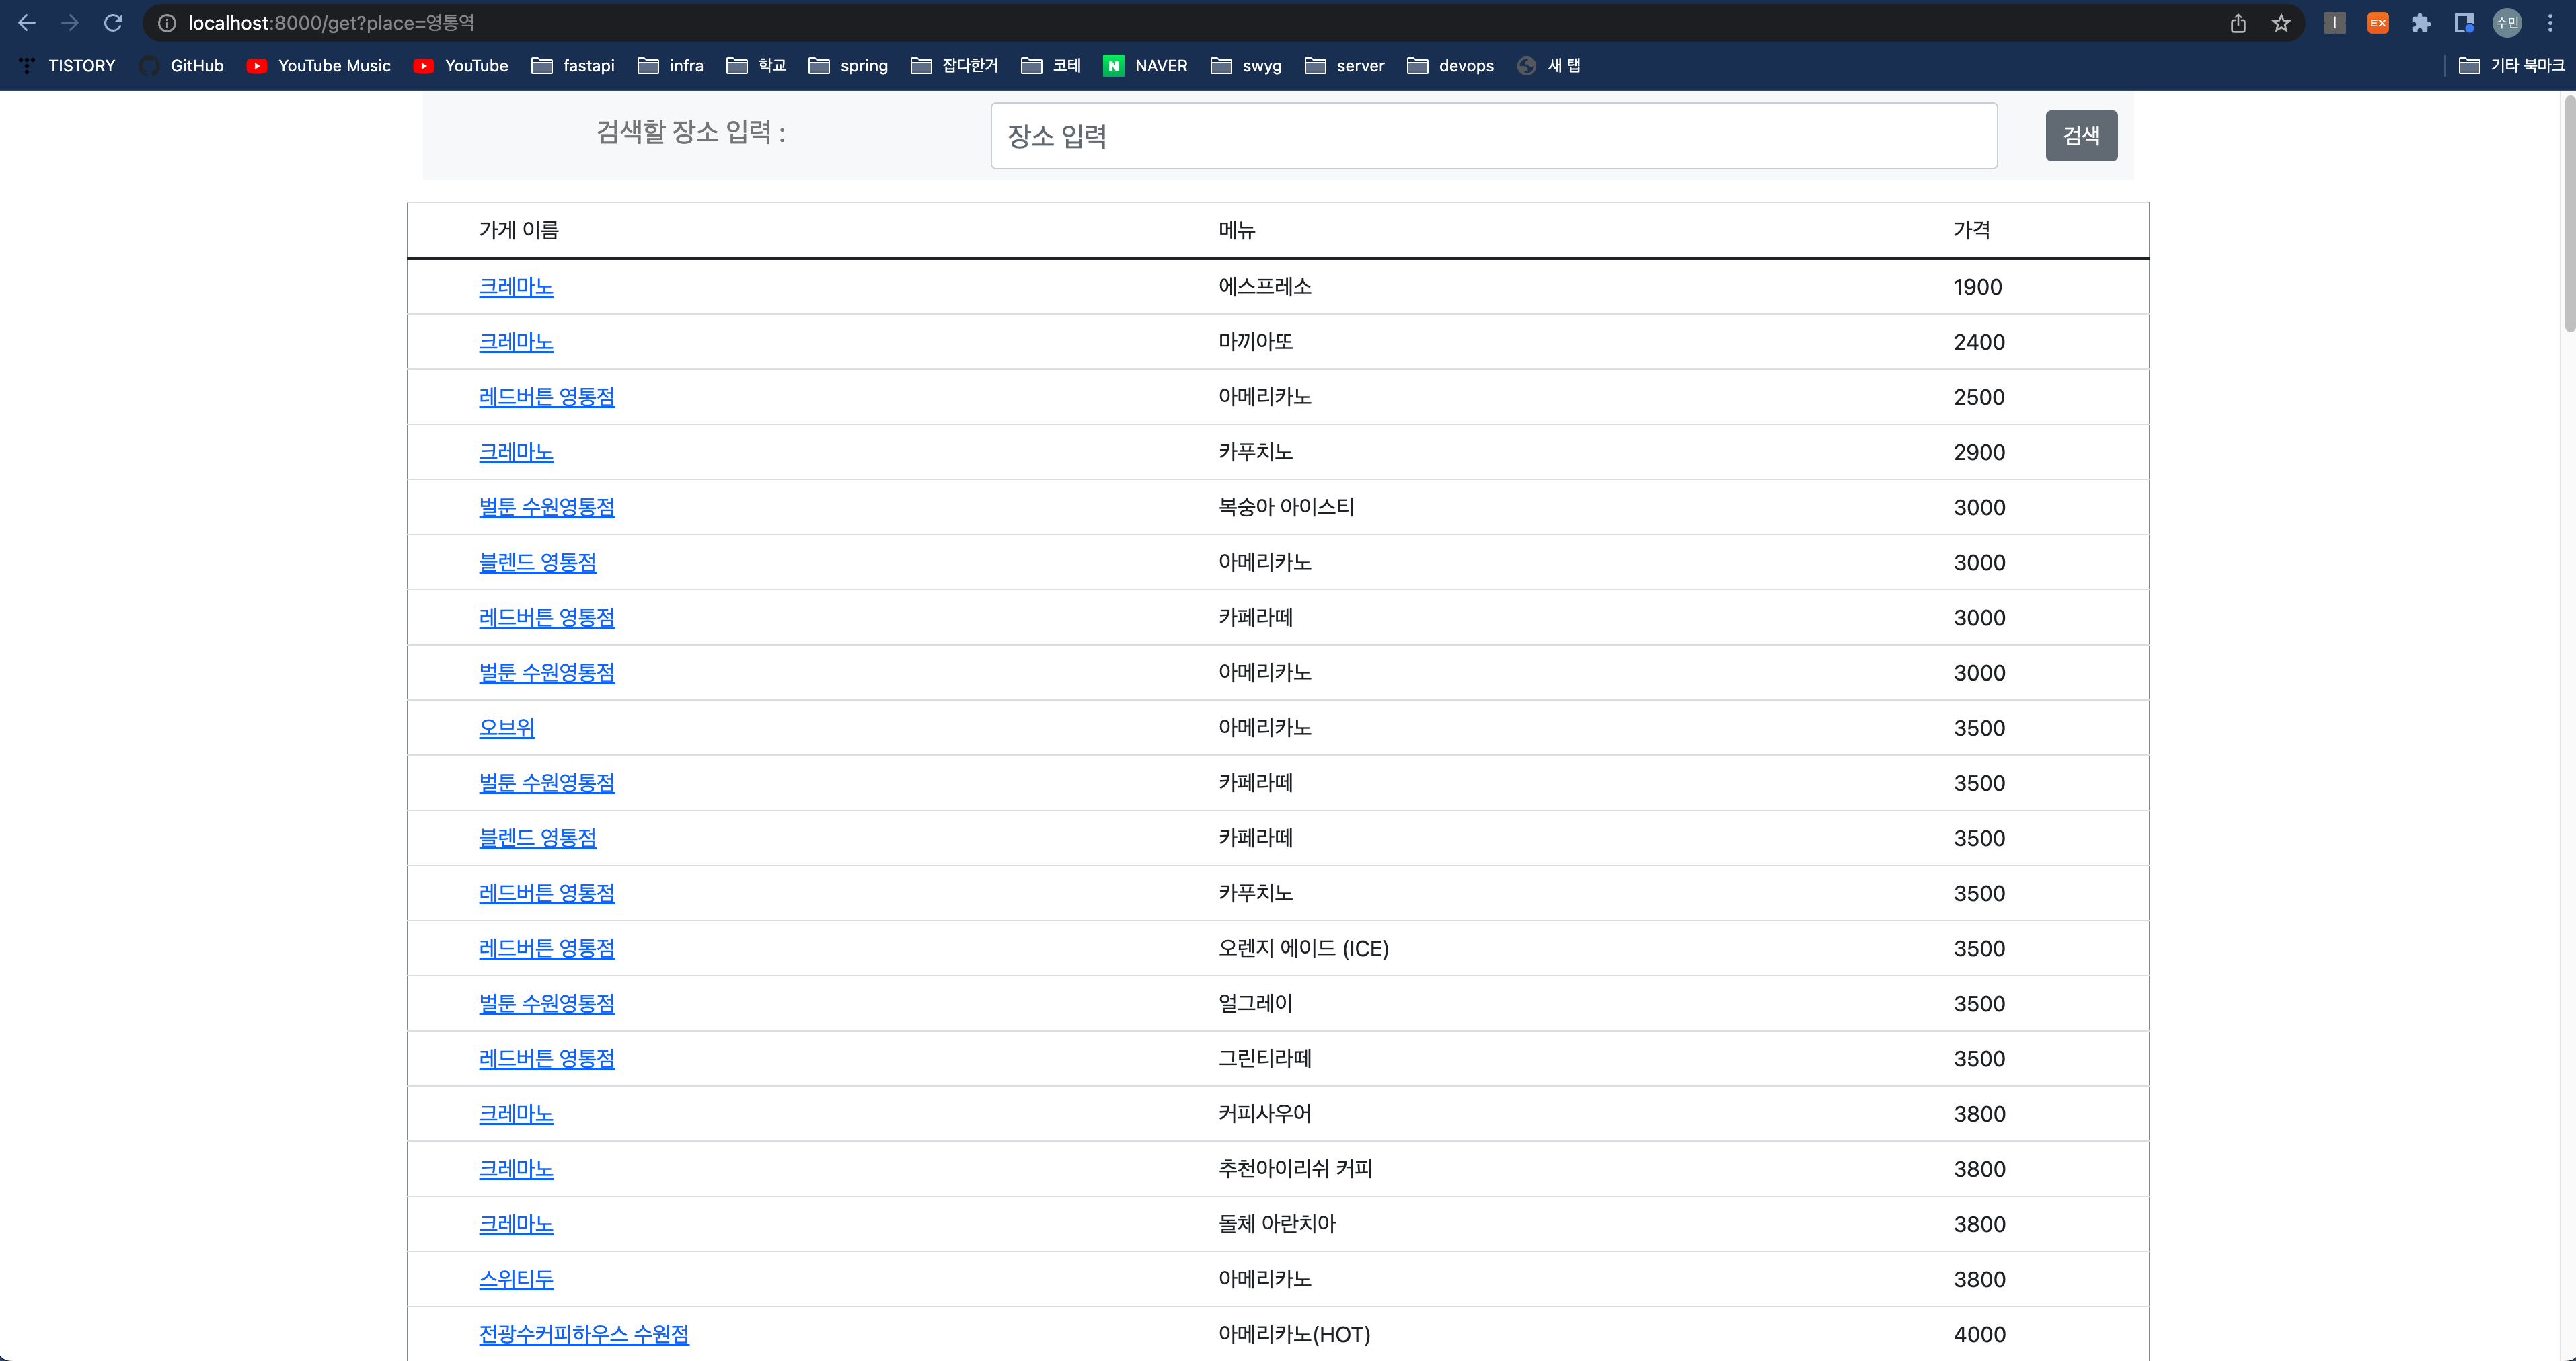